In [1]:
# Import the necessary packages to perform the data analysis

# packages to process and visualize the data
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import json
import folium
#from geopy.geocoders import Nominatim
#from webcolors import rgb_to_name

# packages to improve visual description and analysis
from IPython.core import display as ICD
pd.set_option('display.max_columns', 100)
import os

Import the dataset of top 2000 companies

In [2]:
path='../data/'

In [3]:
#World Bank dataset
GINI_coeff = 'API_SI.POV.GINI_DS2_en_csv_v2_10224868.csv'
ease_of_bus = 'API_IC.BUS.EASE.XQ_DS2_en_csv_v2_10226725.csv'
GDP_tot = 'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv'
GDP_cap = 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv'
time_start_bus = 'API_IC.REG.DURS_DS2_en_csv_v2_10225592.csv'
time_spent_by_bus = 'API_IC.GOV.DURS.ZS_DS2_en_csv_v2_10230883.csv'
tax_rate = 'API_IC.TAX.TOTL.CP.ZS_DS2_en_csv_v2_10226097.csv'

In [4]:
panama_docs=[]
GDP_docs=[]
for i in os.listdir(path):
    if i[:13]=='panama_papers':
        panama_docs.append(i)
    if i[:10]=='API_NY.GDP':
        GDP_docs.append(i)

In [5]:
df_edges_raw = pd.read_csv(path + panama_docs[0],low_memory=False)
df_address_raw = pd.read_csv(path + panama_docs[1],low_memory=False)
df_entity_raw = pd.read_csv(path + panama_docs[2],low_memory=False)
df_intermediary_raw = pd.read_csv(path + panama_docs[3],low_memory=False)
df_officier_raw = pd.read_csv(path + panama_docs[4],low_memory=False)

In [6]:
df_GDP_tot_raw=pd.read_csv(path + GDP_docs[0],skiprows=4,low_memory=False)
df_GDP_cap_raw=pd.read_csv(path + GDP_docs[1],skiprows=4,low_memory=False)
df_tax_weight=pd.read_csv(path+tax_rate, skiprows=4)
df_ease_business=pd.read_csv(path+ease_of_bus,skiprows=4)
df_gini=pd.read_csv(path+GINI_coeff, skiprows=4)

In [ ]:
df_entity_raw

**1) Map the tax heavens jurisdiction in terms of the number of entities they have registered**


Here the jurisdiction column of the entity file is considered. It represents the county where the offshore entity is register.

In [ ]:
df_entity_raw['jurisdiction_description'].unique()

To better represent all the country present on different graph, all the countries appearing less times than a certain number called here threshold are grouped and considered in following steps as `Others`.

In [ ]:
threshold1=1000
df_entity_S1=df_entity_raw.copy()
vc=df_entity_S1.jurisdiction_description.value_counts()
tax_heavens_L=list(vc[vc > threshold1].index)
tax_heavens_S=list(vc[vc <= threshold1].index)
df_entity_S1.loc[~df_entity_S1.jurisdiction_description.isin(tax_heavens_L), 'jurisdiction_description'] = 'Others'
df_entity_S1.jurisdiction_description.value_counts()

A simple histogram is plotted. Logarithmic scale on the $y-axis$ is later applied noticed an approximated exponential distribution. It could be an interesting aspect to investigate. 

In [ ]:
df_entity_S1.jurisdiction_description.value_counts().plot(kind='bar',title='Jurisdiction description', logy=True)
print('Countries in Others category are: ',tax_heavens_S)

A pie chart is also plotted. As mentioned above a heat map of the distribution around the world will be represented.

In [ ]:
df_entity_S1.jurisdiction_description.value_counts().sort_index().plot(kind='pie', figsize=(7, 7), title='Jurisdiction description')

**2) Map countries in the world according to how much they appear in the Panama Papers in terms of the entities**

The same procedure is applied to the `country` column representing the country of origin of the offshore company. As more country are included a bigger threshold needs to be chosen in order to make the plots still readable. Same as before, the count of companies for country will be represent on a heat map.

In [ ]:
df_entity_raw['countries'].unique()

In [ ]:
threshold2=3000
vc=df_entity_S1.countries.value_counts()
tax_evasions_L=list(vc[vc > threshold2].index)
tax_evasions_S=list(vc[vc <= threshold2].index)
df_entity_S1.loc[~df_entity_S1.countries.isin(tax_evasions_L), 'countries'] = 'Others'
df_entity_S1.countries.value_counts()

In [ ]:
df_entity_S1.countries.value_counts().plot(kind='bar',title='Countries', figsize=(10, 7), logy=True)

The value of the `Others` column is very high indicating a quite heavy tail distribution. As before, plotting the bar chart with a logarithm $y-axis$, seems that the distribution has a exponential behaviour at least his first part. 

In [ ]:
df_entity_S1.countries.value_counts().sort_index().plot(kind='pie', figsize=(7, 7), title='Countries')

An interesting fact can be notice from the distribution of the countries. The majority of the entities present in the papers come from a country with already favourable business condition like Honk Kong, Switzerland and Luxembourg or even from a place considered a fiscal paradise (Panama, Jersey). This fact can be explained with a tendency, amplified by globalization, of big companies of starting their international business already from a convenient economy. Later queries will need to take into account these facts, maybe weighting output by indicator of the economic situation of the county of origin. 
More analysis on this aspect will be performed.


**Plotting distributions on a map**

In [ ]:
state_geo_path = path+'countries.geojson'
geo_json_data = json.load(open(state_geo_path))

In [ ]:
geo_json_data['objects']['cantons']['geometries'][0]

In [ ]:
m_world = folium.Map([0,0], tiles='cartodbpositron', zoom_start=2)
m_world

In [ ]:
folium.TopoJson(geo_json_data,'objects.cantons').add_to(m_world)
m_world

**3)GDP_cap Analysis**

As many of the operation performed with the GDP will involve an inner joint between the latter and the entity data frame, the correctness of the operation is investigated. 

In [ ]:
df_GDP_tot_raw

All the following numbers printed show the condition of the data frame as it is right now, after performing the operation later described. The year with less missing values among the ones that follow the 2008 economic crisis (meaning comparable GDP to the present ones) is chosen as measure of the GDP. It is 2014 with 16 missing values.

In [ ]:
print(df_GDP_tot_raw['2017'].isna().sum())
print(df_GDP_tot_raw['2016'].isna().sum())
print(df_GDP_tot_raw['2015'].isna().sum())
print(df_GDP_tot_raw['2014'].isna().sum())
print(df_GDP_tot_raw['2013'].isna().sum())
print(df_GDP_tot_raw['2012'].isna().sum())

In [ ]:
df_GDP_tot_raw[df_GDP_tot_raw['2014'].isna()]

In [ ]:
df_GDP_tot=df_GDP_tot_raw[['Country Name','2014']].copy()
df_GDP_tot.columns = ['countries', 'GDP_tot']
#df_GDP_tot

A new data frame from the `entity` one is created with only the relevant columns. (value_counts is applied) 

In [ ]:
df_vc=pd.DataFrame(df_entity_raw.countries.value_counts())
df_vc.reset_index(level=0, inplace=True)
df_vc.columns = ['countries', 'n_companies']
#df_vc

Now a merge with an inner join the value counts data frame `df_vc` and the `df_GDP_tot` is performed. All the lines with a missing GDP were visualized below (lines of British Virgin Islands, Turks and Caicos Island, Sint Marteen (dutch part), Monaco, Gibraltar, Cayman Islands, Bermuda and Aruba).  The missing values are manually integrated in the `.csv` looking at reliable data online. The check for nan values now shows an empty dataframe.

In [ ]:
df_GDP_tot_entities=df_vc.merge(df_GDP_tot, how='left',left_on='countries', right_on='countries')
print('Number of countries without GDP in the database: ',df_GDP_tot_entities[df_GDP_tot_entities['GDP_tot'].isna()])
#df_GDP_tot_entities

**3)GDP_tot Analysis**

The same analysis procedure is performed on the GDP pro capita data frame. The same lines of GDP were missing, and they were replaced in the same manner as for the total GDP.

In [ ]:
df_GDP_cap_raw

In [ ]:
print(df_GDP_cap_raw['2017'].isna().sum())
print(df_GDP_cap_raw['2016'].isna().sum())
print(df_GDP_cap_raw['2015'].isna().sum())
print(df_GDP_cap_raw['2014'].isna().sum())
print(df_GDP_cap_raw['2013'].isna().sum())
print(df_GDP_cap_raw['2012'].isna().sum())

In [ ]:
df_GDP_cap=df_GDP_cap_raw[['Country Name','2014']].copy()
df_GDP_cap.columns = ['countries', 'GDP_cap']
#df_GDP_cap

In [ ]:
df_GDP_cap_entities=df_GDP_cap.merge(df_vc, how='inner',left_on='countries', right_on='countries')
print('Number of countries without GDP in the database: ',df_GDP_cap_entities[df_GDP_cap_entities['GDP_cap'].isna()])
#df_GDP_cap_entities

**Chechking mean approximation of databases**

In [ ]:
df_tax_weight

In [ ]:
http://127.0.0.1:8888/notebooks/ada/Courses/Applied%20Data%20Analysis/project_ada_akbar/work_in_progress/Tullio.ipynb#cols=[0]+list(range(-9,-1))
cols
df_tax_weight_short=df_tax_weight.iloc[:,cols].copy()
df_tax_weight_short['mean'] = df_tax_weight_short.iloc[:,range(-8,0)].mean(axis=1,numeric_only=True)
df_tax_weight_short

## Chechking yearly dependance

**No GDP filtering and NO weight of GINI**

One interesting fact that could be analysed is the time correlation between the number of Panama Papers during the years and the yearly development of other indicators such as GINI coefficient. 

To do so, the total database is considering for different purpose that will be later explained. Firstly, only the columns regarding the last $15$ years are considered and stored in ``df_GDP_w``. Then an average over these years is considered to obtain a single expression for each country and for mitigate the presence of missing value in the data. The column ``GDP_x`` is added with the mean and all the other columns are dropped.

In [19]:
cols=[0]+list(range(-17,-1))
df_GDP_w=df_GDP_tot_raw.iloc[:,cols].copy()
df_GDP_w['GDP_x'] = df_GDP_w.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)
df_GDP_w=df_GDP_w.drop(df_GDP_w.columns[1:17],axis=1)
#df_GDP_w

Now, different filter can be applied to this data frame that will influence the final data plotted later because of the presence of different joins between the latter dataset and two others. The example showed considers only countries with a GDP higher that a threshold now set to the unrealistic value of $200$, so basically considering all countries present in the data frame. 

In [20]:
df_GDP_w=df_GDP_w[df_GDP_w['GDP_x']>200]#*10e9]
#df_GDP_w=df_GDP_w[df_GDP_w['Country Name']=='Cyprus']
df_GDP_w.head()

,Country Name,GDP_x
0,Aruba,2.402359e+09
1,Afghanistan,1.292136e+10
2,Angola,7.248887e+10
3,Albania,1.044583e+10
4,Andorra,3.188988e+09


For counting the Panama Papers, the `` df_entity_raw`` is firstly joined with ``df_GDP_w`` to consider only countries previously filtered and then all the rows with $NaN$ are dropped. 

In [21]:
df_entity_S2 = df_entity_raw.copy()
df_entity_S2=df_entity_S2.merge(df_GDP_w, how='left',left_on='countries', right_on='Country Name')
df_entity_S2=df_entity_S2[pd.notnull(df_entity_S2['GDP_x'])]
#df_entity_S2

Through converting the year column into index and use it through different function, the count of the number of entities of the countries considered going offshore yearly is calculated.

In [22]:
df_entity_S2.incorporation_date = pd.to_datetime(df_entity_S2.incorporation_date)
df_entity_S2['Year'] = df_entity_S2.apply(lambda row: row['incorporation_date'].year, axis=1)
series_panamas = df_entity_S2.groupby(['Year'], axis=0)['Year'].count()
series_panamas.index = series_panamas.index.astype(int)

Here the other country feature dataset is introduced (in this case `` df_gini``). The dataset is cleaned from useless columns and the filtering join with the GDP dataset is performed. 

In [23]:
series_var = df_gini.copy()
series_var = series_var.drop(series_var.columns[1:4],axis=1).drop(series_var.columns[-1],axis=1)
series_var=series_var.merge(df_GDP_w, how='inner',left_on='Country Name', right_on='Country Name')

Now the latter data frame is average along the column direction, hence leaving all the years column. Different strategies were considered to make the latter average, as the purely arithmetic mean is not ideal. This is because different countries have very different weight in the world economy. One strategy was to use the GDP as weight of the country importance. This did not end up being a good solution as not all the values are available every year and so the absence of the value of a big country in one precise timestep would alter the result a lot. 

In [24]:
series_var[series_var.columns[1:57]]=series_var[series_var.columns[1:57]]#.divide(series_var['GDP_x'], axis='rows')
series_var=series_var[series_var.columns[1:57]]
series_var = series_var.mean(axis=0, skipna=True)
series_var.index = series_var.index.astype(int)

Now the 2 resulting series are plotted in one graph with the following code. Only ear after 1979 are considered as before there is no significant yearly number of Panama Papers. The results are standardized with min-max standardization to plot them on a single graph and easily compared their trend and correlation.

In [25]:
series_panamas_cut = series_panamas[series_panamas.index>=1979]
series_panamas_cut = (series_panamas_cut-series_panamas_cut.min())/(series_panamas_cut.max()-series_panamas_cut.min())
series_var_cut=series_var[series_var.index>=1979]
series_var_cut=(series_var_cut-series_var_cut.min())/(series_var_cut.max()-series_var_cut.min())
df_plot = pd.concat([series_var_cut, series_panamas_cut], axis=1)
df_plot.columns = [['Gini coefficient','Panama papers count']]

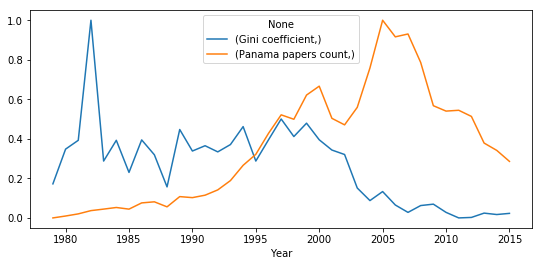

In [27]:
df_plot.plot(figsize=(9,4))

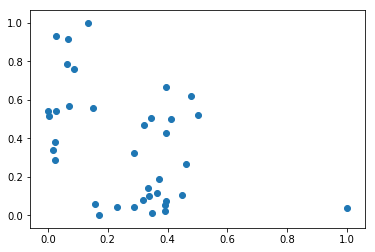

In [26]:
plt.scatter(df_plot['Gini coefficient'], df_plot['Panama papers count'])

The resulting plot that can be seen here above. It can be seen that, on a world scale, there is no clear correlation between the develop of the GINI and the number of worldwide entities in the Panama Papers. To confirm the hypothesis that a higher number of panama paper is a sign of more inequality in the world, the two parameters would be positively correlated, so showing similar trend. All the countries in the world are very different from each other and their behaviour in the Papers can be influenced by a lot of other covariates. A machine learning algorithm could be a nice solution to find some relation using more features, but it would be very limited by the small amount of point available (the number of world countries).

**No GDP filtering and weight (dividing) of GINI**

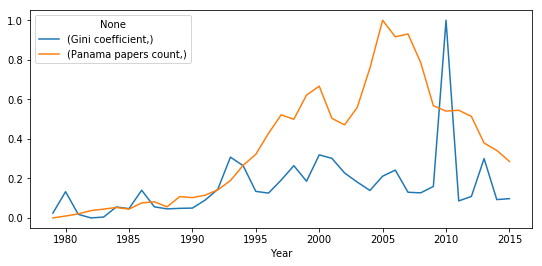

In [29]:
series_var = df_gini.copy()
series_var = series_var.drop(series_var.columns[1:4],axis=1).drop(series_var.columns[-1],axis=1)
series_var=series_var.merge(df_GDP_w, how='inner',left_on='Country Name', right_on='Country Name')
#Here the weighting of GINI is performed 
series_var[series_var.columns[1:57]]=series_var[series_var.columns[1:57]].divide(series_var['GDP_x'], axis='rows')
series_var=series_var[series_var.columns[1:57]]
series_var = series_var.mean(axis=0, skipna=True)
series_var.index = series_var.index.astype(int)
series_panamas_cut = series_panamas[series_panamas.index>=1979]
series_panamas_cut = (series_panamas_cut-series_panamas_cut.min())/(series_panamas_cut.max()-series_panamas_cut.min())
series_var_cut=series_var[series_var.index>=1979]
series_var_cut=(series_var_cut-series_var_cut.min())/(series_var_cut.max()-series_var_cut.min())
df_plot = pd.concat([series_var_cut, series_panamas_cut], axis=1)
df_plot.columns = [['Gini coefficient','Panama papers count']]
df_plot.plot(figsize=(9,4))

In the graph above the same procedure as descripted above is used but this time the GINI coefficient is weight by dividing it by the GDP. The scatter plot is not showed no consequent time dependence could be seen in that. In this occasion the result does not seem to show any relation. The weighting of the GINI moderates its fluctuations, but missing data creates outliers. A pseudo correlation can be noticed in the first $15 - 17$ years of the plot.

**No GDP filtering and NO weight of Tax rate**

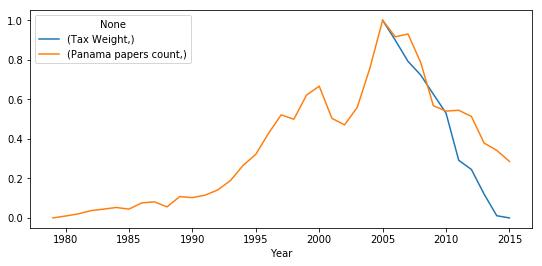

In [30]:
series_var = df_tax_weight.copy()
series_var = series_var.drop(series_var.columns[1:4],axis=1).drop(series_var.columns[-1],axis=1)
series_var=series_var.merge(df_GDP_w, how='inner',left_on='Country Name', right_on='Country Name')
series_var[series_var.columns[1:57]]=series_var[series_var.columns[1:57]]#.divide(series_var['GDP_x'], axis='rows')
series_var=series_var[series_var.columns[1:57]]
series_var = series_var.mean(axis=0, skipna=True)
series_var.index = series_var.index.astype(int)
series_panamas_cut = series_panamas[series_panamas.index>=1979]
series_panamas_cut = (series_panamas_cut-series_panamas_cut.min())/(series_panamas_cut.max()-series_panamas_cut.min())
series_var_cut=series_var[series_var.index>=1979]
series_var_cut=(series_var_cut-series_var_cut.min())/(series_var_cut.max()-series_var_cut.min())
df_plot = pd.concat([series_var_cut, series_panamas_cut], axis=1)
df_plot.columns = [['Tax Weight','Panama papers count']]
df_plot.plot(figsize=(9,4))

For the Tax rate the same procedure applied before to the GINI is done but this time instead of GINI; tax weight is considered. No weighting is considered. The plot shows in the very last part the expected relation of decreasing tax in the world economy contemporary to a decreasing in also the number of entities going offshore. This relation is limited to the last $10$ year of the plot as the `` df_tax_weight`` does not contains enough values to plot it continuously from 1979. So, no general conclusion can be draw.

**Almost G7 economies filtering and NO weight of GINI**

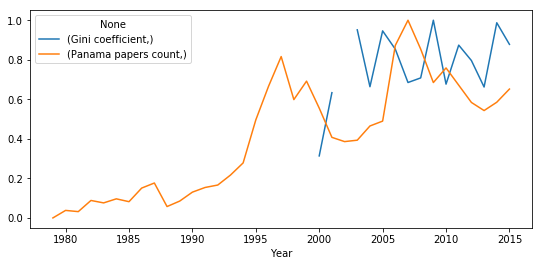

In [31]:
df_GDP_w=df_GDP_tot_raw.iloc[:,cols].copy()
df_GDP_w['GDP_x'] = df_GDP_w.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)
df_GDP_w=df_GDP_w.drop(df_GDP_w.columns[1:17],axis=1)
#Country filtering
df_GDP_w=df_GDP_w[df_GDP_w['GDP_x']>200*10e9]
df_entity_S2 = df_entity_raw.copy()
df_entity_S2=df_entity_S2.merge(df_GDP_w, how='left',left_on='countries', right_on='Country Name')
df_entity_S2=df_entity_S2[pd.notnull(df_entity_S2['GDP_x'])]
df_entity_S2.incorporation_date = pd.to_datetime(df_entity_S2.incorporation_date)
df_entity_S2['Year'] = df_entity_S2.apply(lambda row: row['incorporation_date'].year, axis=1)
series_panamas = df_entity_S2.groupby(['Year'], axis=0)['Year'].count()
series_panamas.index = series_panamas.index.astype(int)
series_var = df_gini.copy()
series_var = series_var.drop(series_var.columns[1:4],axis=1)#.drop(series_var.columns[-1],axis=1)
series_var=series_var.merge(df_GDP_w, how='inner',left_on='Country Name', right_on='Country Name')
series_var[series_var.columns[1:57]]=series_var[series_var.columns[1:57]].divide(series_var['GDP_x'], axis='rows')
series_var=series_var[series_var.columns[1:57]]
series_var = series_var.mean(axis=0, skipna=True)
series_var.index = series_var.index.astype(int)
series_panamas_cut = series_panamas[series_panamas.index>=1979]
series_panamas_cut = (series_panamas_cut-series_panamas_cut.min())/(series_panamas_cut.max()-series_panamas_cut.min())
series_var_cut=series_var[series_var.index>=1979]
series_var_cut=(series_var_cut-series_var_cut.min())/(series_var_cut.max()-series_var_cut.min())
df_plot = pd.concat([series_var_cut, series_panamas_cut], axis=1)
df_plot.columns = [['Gini coefficient','Panama papers count']]
df_plot.plot(figsize=(9,4))